In [1]:
import cv2
import os 
from tqdm import tqdm
import numpy as np
from random import shuffle
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Model

In [4]:
TRAIN_DIR='D://ML/Datasets/dogs-vs-cats/train/train'
TEST_DIR='D://ML/Datasets/dogs-vs-cats/test1/test1'

In [5]:
IMG_SIZE=50
LR=0.001
#LR=1e-3

MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'2conv-basic')

In [6]:
def label_img(img):
    label=img.split('.')[0]
    if label=='cat':
        return [1]
    elif label=='dog':
        return [0]

In [7]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path=os.path.join(TRAIN_DIR, img)
        img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    return training_data

In [8]:
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    shuffle(testing_data)
    return testing_data

In [9]:
#test_data=process_test_data()

In [10]:
train_data=create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:38<00:00, 114.47it/s]


In [11]:
x = train_data[:-1000]
y = train_data[-1000:]

In [12]:
print(len(train_data),len(train_data[:-1000]),len(train_data[-1000:])) #indexing in list starts from -1 from end

25000 24000 1000


In [13]:
x[0][0].shape

(50, 50)

In [14]:
#Separating features and labels in training and testing set created from main training dataset

x_train = np.array([i[0] for i in x]).reshape(-1,50,50,1)
y_train = np.array([i[1] for i in x])

In [15]:
x_test = np.array([i[0] for i in y]).reshape(-1,50,50,1)
y_test = np.array([i[1] for i in y])

In [16]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(24000, 50, 50, 1) (24000, 1) (1000, 50, 50, 1) (1000, 1)


In [17]:
x_train, x_test=x_train/255.0, x_test/255.0
y_train, y_test=y_train.flatten(), y_test.flatten()

In [18]:
print(y_train.shape)

(24000,)


In [19]:
x_train[0]

array([[[0.53333333],
        [0.51372549],
        [0.49411765],
        ...,
        [0.27843137],
        [0.12941176],
        [0.12941176]],

       [[0.40392157],
        [0.52941176],
        [0.45490196],
        ...,
        [0.65882353],
        [0.50980392],
        [0.30588235]],

       [[0.56862745],
        [0.50588235],
        [0.5254902 ],
        ...,
        [0.69803922],
        [0.68235294],
        [0.69803922]],

       ...,

       [[0.5254902 ],
        [0.58431373],
        [0.62745098],
        ...,
        [0.5254902 ],
        [0.91372549],
        [0.94117647]],

       [[0.45490196],
        [0.70980392],
        [0.47058824],
        ...,
        [0.62745098],
        [0.96078431],
        [0.63529412]],

       [[0.58039216],
        [0.70980392],
        [0.64313725],
        ...,
        [0.82745098],
        [0.92156863],
        [0.50588235]]])

In [20]:
print(x_train[0].shape)

(50, 50, 1)


In [21]:
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)


#x = Flatten()(x)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2,activation='softmax')(x)

model = Model(i,x)

In [22]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [23]:
x_train.shape[0]

24000

In [24]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train,y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

In [25]:
r = model.fit_generator(train_generator, validation_data=(x_test,y_test), steps_per_epoch=steps_per_epoch, epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 750 steps, validate on 1000 samples
Epoch 1/50
750/750 [==============================] - 17s 22ms/step - loss: 0.6591 - accuracy: 0.6226 - val_loss: 0.6977 - val_accuracy: 0.5390
Epoch 2/50
750/750 [==============================] - 13s 18ms/step - loss: 0.5440 - accuracy: 0.7223 - val_loss: 0.5560 - val_accuracy: 0.7370
Epoch 3/50
750/750 [==============================] - 13s 17ms/step - loss: 0.4798 - accuracy: 0.7664 - val_loss: 0.7083 - val_accuracy: 0.6090
Epoch 4/50
750/750 [==============================] - 13s 18ms/step - loss: 0.4297 - accuracy: 0.7983 - val_loss: 0.4436 - val_accuracy: 0.8100
Epoch 5/50
750/750 [==============================] - 13s 18ms/step - loss: 0.3972 - accuracy: 0.8159 - val_loss: 0.4046 - val_accuracy: 0.8180
Epoch 6/50
750/750 [==============================] - 13s 18ms/step - loss: 0.3666 - accuracy: 0.8333 - val_loss: 0.4051 - val_accura

In [29]:
model.save("my_model_with_datagen_withglobal")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model_with_datagen_withglobal\assets


In [26]:
print("Training result: ",model.evaluate(x_train,y_train))
print("Testing result: ",model.evaluate(x_test,y_test))

24000/24000 [==============================] - 4s 169us/sample - loss: 0.1725 - accuracy: 0.9273
Training result:  [0.17252878794819115, 0.9272917]
1000/1000 [==============================] - 0s 167us/sample - loss: 0.2506 - accuracy: 0.9000
Testing result:  [0.2506258988380432, 0.9]


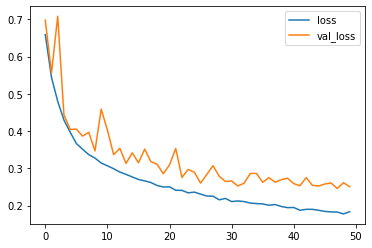

In [27]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

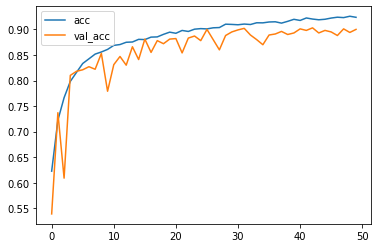

In [28]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

In [71]:
labels="""dog,cat""".split(',')
labels

['dog', 'cat']

In [37]:
p_test=model.predict(x_test).argmax(axis=1)
p_test

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [72]:
missclassified_idx=np.where(p_test!=y_test)[0]
missclassified_idx

array([ 12,  16,  26,  27,  29,  33,  46,  49,  84, 101, 102, 146, 149,
       173, 176, 178, 180, 184, 197, 210, 242, 252, 256, 261, 267, 271,
       279, 282, 288, 304, 310, 324, 335, 351, 352, 363, 375, 385, 394,
       408, 411, 420, 430, 431, 434, 438, 449, 457, 484, 493, 496, 504,
       537, 551, 579, 581, 593, 594, 595, 606, 608, 630, 644, 659, 662,
       663, 668, 671, 675, 677, 685, 731, 734, 735, 742, 749, 754, 770,
       778, 809, 812, 827, 838, 854, 860, 862, 865, 872, 889, 891, 918,
       919, 928, 943, 958, 966, 981, 987, 992, 996], dtype=int64)

Text(0.5, 1.0, 'True label: dog, Predicted label: cat')

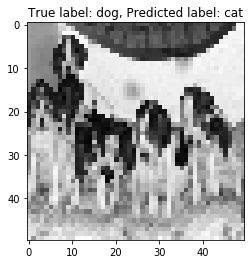

In [82]:
i=np.random.choice(missclassified_idx)
plt.imshow(x_test[i].reshape(50,50),cmap='gray')
plt.title("True label: %s, Predicted label: %s" %(labels[y_test[i]],labels[p_test[i]]))

In [58]:
path="D://Downloads/test.jpg"

In [61]:
image=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
image=cv2.resize(image,(50,50))/255.0

In [65]:
image=np.array(image).reshape(-1,50,50,1)
image.shape

(1, 50, 50, 1)

In [83]:
pred=model.predict(image).argmax(axis=1)
print(labels[pred[0]])

dog


In [30]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

NameError: name 'test_data' is not defined

<Figure size 432x288 with 0 Axes>